In [1]:
from __future__ import division, print_function

import json
import gc
import gzip
import numpy as np
import os
import string

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from glob import iglob
from IPython.display import display, HTML
from operator import itemgetter
from scipy.sparse.linalg import svds
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

In [2]:
def load_reviews(min_reviews=100):
    reviews = defaultdict(list)
    for filename in iglob("data/reviews/*.json"):
        with open(filename) as f:
            loaded = json.load(f)
            if len(loaded) >= min_reviews:
                for review in loaded:
                    reviews[review["app_id"]].append(review)
    app_ids = np.array(sorted(reviews.keys()))
    app_id_to_index = {app_id: i for i, app_id in enumerate(app_ids)}
    corpus = [" ".join(r["body"] for r in reviews[app_id]) for app_id in app_ids]
    del reviews
    gc.collect()
    return app_ids, app_id_to_index, corpus

def load_reviews_gzip():
    with gzip.open("data/filtered_reviews.gzip", "r", 5) as f:
        reviews = json.load(f)
    app_ids = np.array(sorted(map(int, reviews.iterkeys())))
    app_id_to_index = {app_id: i for i, app_id in enumerate(app_ids)}
    corpus = [" ".join(r["body"] for r in reviews[str(app_id)]) 
              for app_id in app_ids]
    del reviews
    gc.collect()
    return app_ids, app_id_to_index, corpus

In [3]:
app_ids, app_id_to_index, corpus = load_reviews_gzip()

In [4]:
vectorizer = CountVectorizer(stop_words="english",
                             max_df=.9,
                             min_df=10,
                             ngram_range=(1,2),
                             max_features=6000)

term_doc_matrix = vectorizer.fit_transform(corpus)
print(term_doc_matrix.shape)

KeyboardInterrupt: 

In [ ]:
# We can use this graph to check how many dimensions we actually live in
_, s, _ = svds(term_doc_matrix.T.astype(np.float), k=100)
plt.plot(s[::-1]/s.max())
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [11]:
n_topics = 20
model = LDA(n_topics=n_topics, max_iter=10, n_jobs=4, verbose=1)
res = model.fit_transform(term_doc_matrix)
normalized_res = normalize(res)
similarities = normalized_res.dot(normalized_res.T)

C:\Program Files\Anaconda2\envs\cs4300\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [12]:
tsne = TSNE(verbose=1)
projected_docs = tsne.fit_transform(res)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2292
[t-SNE] Computed conditional probabilities for sample 2000 / 2292
[t-SNE] Computed conditional probabilities for sample 2292 / 2292
[t-SNE] Mean sigma: 0.124595
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.116406
[t-SNE] Error after 325 iterations: 1.116406


{u'Free to Play': 'b', u'Indie': 'y', u'Strategy': 'c', u'RPG': 'm', u'Action': 'g', u'Early Access': 'r'}


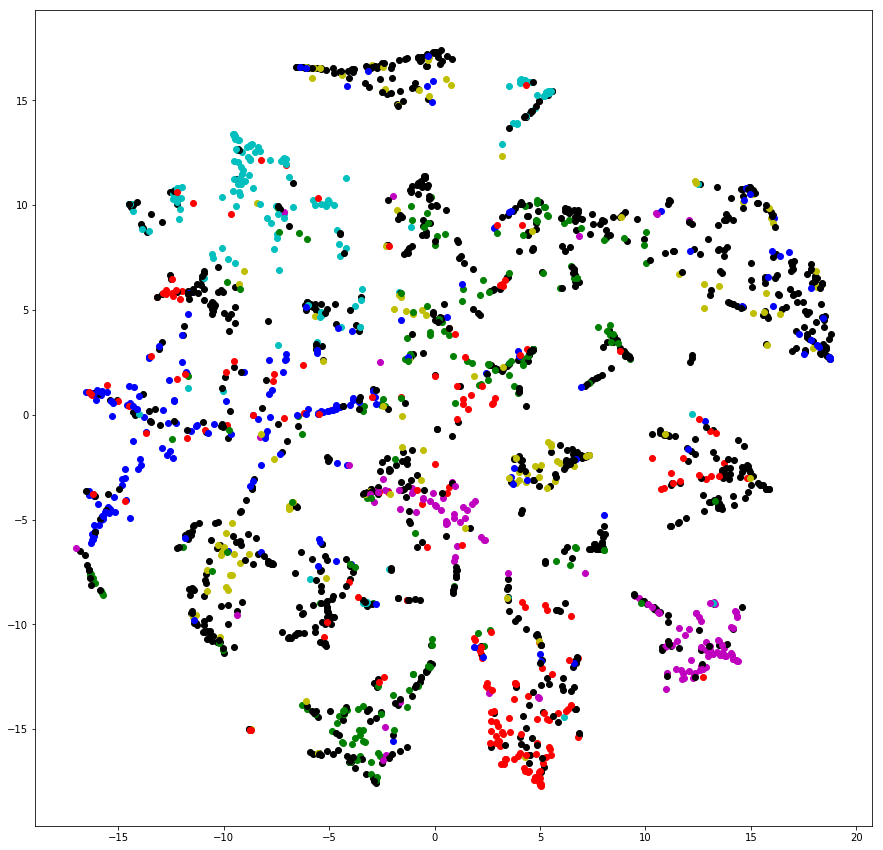

In [18]:
color_index = ["b", "g", "r", "c", "m", "y"]
with open("data/steamspy_games.json") as f:
    games = {int(app_id): game 
             for app_id, game in json.load(f).iteritems() 
             if int(app_id) in app_id_to_index}

best_ranking_tags = defaultdict(int)
for g in games.itervalues():
    if len(g["tags"]) > 0:
        best_ranking_tags[max(g["tags"].iteritems(), key=itemgetter(1))[0]] += 1
tag_names, tag_scores = zip(*best_ranking_tags.iteritems())
tag_names, tag_scores = np.array(tag_names), np.array(tag_scores)
tag_names = tag_names[np.argsort(tag_scores)[:-len(color_index)-1:-1]]
tag_to_color = {name: color for name, color in zip(tag_names, color_index)}
print(tag_to_color)

plt.figure(figsize=(15,15))
# plt.scatter(projected_docs[:,0],projected_docs[:,1])
for i, app_id in enumerate(app_ids):
    if len(games[app_id]["tags"]) > 0:
        best_tag = max(games[app_id]["tags"].iteritems(), key=itemgetter(1))[0]
        plt.scatter(projected_docs[i,0], projected_docs[i, 1], color=tag_to_color.get(best_tag, "k"))
plt.show()

In [73]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def print_ranking(similarities, games, app_id, limit=10):
    link = """<a href="http://store.steampowered.com/app/%d">%s</a>"""
    print("Showing ranking for %s (%d)"%(games[app_id]["name"], app_id))
    index = app_id_to_index[app_id]
    ranking = app_ids[np.argsort(similarities[index, :])][::-1]
    for i in xrange(limit):
        display(HTML(link%(ranking[i], games[ranking[i]]["name"])))

def save_compressed_matrix(app_ids, 
                           compressed_matrix,
                           filename="data/compressed_matrix.npy"):
    with open(filename, "wb") as f:
        np.save(f, np.column_stack((app_ids, compressed_matrix)))
    
def load_compressed_matrix(filename="data/compressed_matrix.npy"):
    with open(filename, "rb") as f:
        arr = np.load(f)
    return arr[:, 0].astype(np.int), arr[:, 1:]

In [44]:
print_top_words(model, vectorizer.get_feature_names(), 10)

Topic #0:
cards card free play match server pvp pay win servers items skill
Topic #1:
car cars racing vr driving physics race drive tracks track
Topic #2:
half life simulator software dlc sim train program mod engine mods
Topic #3:
combat boss enemies fighting souls dark bosses controller sonic attack
Topic #4:
multiplayer maps fps weapons servers shooter guns cod gun server
Topic #5:
mmo combat quests ubisoft batman uplay creed quest assassin missions
Topic #6:
port fps crashes crash controller dlc windows gta console missions
Topic #7:
war total war battle campaign battles board warhammer multiplayer king ai
Topic #8:
weapons zombies enemies zombie shooter guns gun shoot weapon shooting
Topic #9:
tower defense tower defense mobile towers pop addictive upgrade clicker upgrades
Topic #10:
ship ships star wars lego planet john planets combat star wars
Topic #11:
stealth missions mission enemies ai ex deus deus ex enemy flight
Topic #12:
city ai strategy civ war management cities 4x dlc 

In [45]:
subnautica = 264710
dark_souls = 211420
golf_with_your_friends = 431240

In [46]:
print_ranking(similarities, games, subnautica)
print_ranking(similarities, games, dark_souls)
print_ranking(similarities, games, golf_with_your_friends)

Showing ranking for Subnautica (264710)


Showing ranking for DARK SOULS™: Prepare To Die™ Edition (211420)


Showing ranking for Golf With Your Friends (431240)


In [74]:
save_compressed_matrix(app_ids, normalized_res)

In [76]:
loaded_app_ids, loaded_matrix = load_compressed_matrix()